[Principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is one of the most used techniques for exploratory data analysis and preprocessing.

There are different formulations of PCA. A fundamental concept that occurs in several formulations are covariance matrices. In this lab, we thus first take a look at them. Then we investigate different ways to compute the principal component (PC) directions and scores. 

In [1]:
# imports
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# for interactive figures, requires installation of ipympl
#%matplotlib ipympl  

# default
%matplotlib inline

## Check package versions

In [2]:
print('Package versions used: ')
import matplotlib as mpl
import sklearn
print('* Scipy: ', sp.__version__)
print('* Numpy: ', np.__version__)
print('* Matplotlib: ', mpl.__version__)
print('* Seaborn', sns.__version__)
print('* Sklearn', sklearn.__version__)

Package versions used: 
* Scipy:  1.5.2
* Numpy:  1.19.2
* Matplotlib:  3.3.2
* Seaborn 0.11.1
* Sklearn 0.23.2


DICE packages: 
* Scipy:  1.3.3
* Numpy:  1.17.4
* Matplotlib:  3.1.2dd
* Seaborn 0.10.0
* Sklearn0.22.2.post1

Also tested with:
* Scipy:  1.5.2
* Numpy:  1.19.2
* Matplotlib:  3.3.2
* Seaborn 0.11.1
* Sklearn 0.23.2

# Covariance structure of data

## Generating covariance matrices
Covariance matrices are by definition [symmetric positive semi-definite](https://en.wikipedia.org/wiki/Positive-definite_matrix#Positive-semidefinite). One property of positive semi-definite matrices is that their eigenvalues are all non-negative. 

The function  `generate_spsd_matrix()` generates a random symmetric positive semi-definite matrix. The `random_seed` parameter can be used to set the numpy random seed in order to ensure reproducible results. Appendix A.9 "Positive Semi-definite and Definite Matrices" in the lecture notes explains why this function produces positive semi-definite matrices.

In [3]:
def generate_spsd_matrix(d, random_seed=None):
    """Reproducible random generation of symmetric 
    positive semi-definite matrices. 
    
    Parameters
    ----------
    d : integer
        Number of dimensions.
    
    random_seed : integer
        Random seed number.
        
    Returns 
    ----------
    A : ndarray, shape (n,n)
        Symmetric positive definite matrix.
    
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)
    A = np.random.randn(d,d)
    return np.dot(A.T, A)

We also provide you with the following function that checks whether a given matrix is positive semi-definite. It uses `numpy.linalg.eigh()` function to compute the eigenvalue decomposition. Check out its [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) to learn about its usage.

In [4]:
def is_positive_semi_definite(a):
    """Tests whether a matrix is symmetric positive 
    semi-definite.
    
    Parameters
    ----------
    a : ndarray, shape (n,n)
        Symmetric matrix.
      
    Returns 
    ----------
    True if matrix is positive semi-definite.
        
    Raises 
    ----------
    ValueError
        If the provided matrix is not real or symmetric.
    """
    
    a = np.asarray(a)
    
    # Check that matrix is real
    if not np.all(np.isreal(a)):
        raise ValueError("The provided matrix is \
                         not real.")
    
    # Check that matrix is symmetric
    is_symmetric = np.array_equal(a, a.T)
    if is_symmetric is not True:
        raise ValueError("The provided matrix is \
                         not symmetric.")
    
    # Eigenvalue decomposition
    eigval, _ = np.linalg.eigh(a)
    if np.all(eigval >= 0):
        return True
    else:
        return False

Let us check whether the functions do what we want them to do:

In [5]:
# Example with a pos-def matrix
a = generate_spsd_matrix(d=10, random_seed=10)
if is_positive_semi_definite(a):
    print("Matrix is positive semi-definite.")
else:
    print("Matrix is not positive semi-definite.")    

Matrix is positive semi-definite.


In [6]:
# Example with a random symmetric matrix
b = np.random.standard_normal((5,5))
b = b + b.T  # to make the matrix symmetric
if is_positive_semi_definite(b):
    print("Matrix is positive semi-definite.")
else:
    print("Matrix is not positive semi-definite.")    

Matrix is not positive semi-definite.


##  Question 1: Generating data with a given covariance matrix---the math

Suppose that you want to sample (i.e. generate) some data points with a specific mean vector and covariance matrix. We will assume that we have access to a method that generates random variables with zero mean and unit variance, e.g. `np.random.standard_normal` for Gaussian data. 

We know that if a random variable variable $x$ has zero mean and unit variance, then $y = \sigma x + m$ has mean $m$ and variance $\sigma^2$ . Therefore, we can use this property to sample from an arbitrary univariate distribution with mean $m$ and variance $\sigma^2$ if we can sample from its "standardised" version of mean zero and variance 1.

By repeating the process described above $d$ times, we can sample from a $d$-dimensional distribution with an arbitrary mean vector and diagonal covariance matrix. But, how can we sample from a multivariate distribution with given covariance matrix $\mathbf{C}$? The answer is through decomposing the covariance matrix via its [eigen (or spectral) decomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix). For a real symmetric matrix $\mathbf{C}$ (such as covariance matrices), the decomposition takes the following form
$$\mathbf{C} = \mathbf{U} \mathbf{\Lambda} \mathbf{U}^T$$
where $\mathbf{U}$ is an orthogonal matrix containing the eigenvectors of $\mathbf{C}$ and $\mathbf{\Lambda}$ is a diagonal matrix whose entries are the non-negative eigenvalues of $\mathbf{C}$. Now, you might wonder how this decomposition can help us sample from a multivariate distribution.

Assume that $\mathbf{x}$ is a multivariate random variable with zero mean and unit covariance matrix, and $\mathbf{C} = \mathbf{U} \mathbf{\Lambda} \mathbf{U}^T$ is the eigendecomposition of $\mathbf{C}$. Then
$$\mathbf{y} =  \mathbf{U} \mathbf{\Lambda}^{1/2} \mathbf{x} + \mathbf{m}$$
has mean $\mathbf{m}$ and covariance $\mathbf{C} $.

Using properties shown in Chapter 1 of the lecture notes, verify that $\mathbf{y}$ has mean $\mathbf{m}$ and covariance $\mathbf{C} $.

*Your answer goes here*

Using linearity of expectation, we have:
$E\left[ \mathbf{y} \right] = E \left[ \mathbf{U} \mathbf{\Lambda}^{1/2} \mathbf{x} + \mathbf{m} \right] = \mathbf{U} \mathbf{\Lambda}^{1/2}  E \left[ \mathbf{x} \right] + E \left[\mathbf{m} \right] =  \mathbf{0} + \mathbf{m} = \mathbf{m}$.

From the lecture notes, we know that a variable $\mathbf{Ax+b}$ has covariance matrix $\mathbf{A}\text{Cov}[\mathbf{x}]\mathbf{A^\top}$. With $\text{Cov}[\mathbf{x}]$ equal to the identity matrix and $\mathbf{A}= \mathbf{U} \mathbf{\Lambda}^{1/2}$, we have

$$\text{Cov}\left[ \mathbf{y} \right] =  \mathbf{U} \mathbf{\Lambda}^{1/2} \mathbf{\Lambda}^{1/2} \mathbf{U} ^T$$
where $\mathbf{\Lambda}$ is a diagonal matrix. We thus have
$$\text{Cov}\left[ \mathbf{y} \right] = \mathbf{U} \mathbf{\Lambda} \mathbf{U} ^T$$
This is exactly the eigenvalue decomposition of $\mathbf{C}$ and hence the result holds.

## Question 2: Generating data with a given covariance matrix---the code

The result above implies the following procedure to sample one data point from a multivariate distribution with mean $\mathbf{m}$ and covariance matrix $\mathbf{C}$ if sampling from a "standardised" distribution is possible:

1. Compute the eigendecomposition of the covariance matrix, so that $\mathbf{C} = \mathbf{U} \mathbf{\Lambda} \mathbf{U}^T$
2. Sample a data point $\mathbf{x} \in \mathbb{R}^d$ from the "standardised" distribution (i.e. zero mean, identity covariance matrix).
3. Compute $\mathbf{y} =  \mathbf{U} \mathbf{\Lambda}^{1/2} \mathbf{x} + \mathbf{m}$.

Write a function that generates $n$ random samples from a multivariate normal distribution with given mean vector and  covariance matrix. You should make use of the [`np.random.standard_normal`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.standard_normal.html) function that generates samples from a standard multivariate gaussian distribution and the eigendecomposition of the covariance matrix. For computing the eigendecomposition of a symmetric matrix you should use the [`numpy.linalg.eigh()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) function.

Finally, generate a 3 x 3 random covariance matrix `C` by using the `generate_positive_semi_definite()` function.  Use the function you just wrote to generate 1 million random samples with zero mean and covariance matrix `C`. Compute the empirical covariance matrix of the data (you can use [`numpy.cov()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html)) and check that it is a good estimate of the true covariance matrix `C`.

**Important:**

There are different conventions on how data are stored in matrices: There is the "rows are variables, columns are observations" convention where the data matrix `X` has size $d \times n$, with $d$ denoting the dimensionality and $n$ the number of samples. This convention is used in the lecture notes and many text books, and e.g. by `numpy.cov` (see the default `rowvar=True`).

There is also the reverse convention where `X`is the transpose, i.e. it is a $n \times d$ matrix. This "rows are observations, columns are variables" is e.g. followed by `Pandas` and `scikit-learn`.

It is up to you which convention you follow. The first convention has the advantage that code more closely follows the math if you represent random vectors as column vectors (which is usually done). For example if we have a random (column) vector $\mathbf{x}$ of mean zero, the covariance is $\mathbb{E}[\mathbf{xx^\top}]$. If we work with $d \times n$ data matrices `X`, the formula can be implemented as `1/n X@X.T`, which is of the same form as the math formula. The second convention is advantageous if you use e.g. `Pandas` and `scikit-learn` libraries (and if you derived the math formula assuming the random vectors are row vectors). However, you have to transpose the math results if established using column vectors. For example $\mathbf{y} =  \mathbf{U} \mathbf{\Lambda}^{1/2} \mathbf{x} + \mathbf{m}$ becomes
$$\mathbf{y}^\top =  \mathbf{x}^\top (\mathbf{U}\mathbf{\Lambda}^{1/2})^\top + \mathbf{m}^\top = \mathbf{x}^\top \mathbf{\Lambda}^{1/2}  \mathbf{U}^\top + \mathbf{m}^\top$$
Alternatively, you may just make sure that your functions and methods implement whatever interface you need, but possibly transpose input and output matrices at the beginning and end of your code, respectively. The transpose [returns a view in numpy](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html) so that there are no memory issues in this approach.

As an exercise, follow here the $n \times d$ convention.

In [7]:
def sample_multivariate_normal_eig(mean, cov, n, random_seed=None):
    """Sample from multivariate normal distribution
    with given mean and covariance matrix by
    using eigendecomposition of covariance matrix.
    
    Parameters
    ----------
    mean  : array, shape (d,)
        Mean vector.
        
    cov : array, shape (d,d)
        Covariance matrix.
    
    n : integer
        Number of samples.
        
    random_seed : integer (optional)
        Random seed.
      
    Returns 
    ----------
    X : array, shape(n, d)
        Random samples.
    
        
    Raises 
    ----------
    ValueError
        If the provided matrix is not positive definite or if dimension of the
        provided mean and covariance matrix does not match.
        
        
    """

    # Your code goes here
    
    
    # Check that covariance matrix is positive semi-definite.
    is_pd = is_positive_semi_definite(cov)
    if is_pd is not True:
        print(is_pd)
        raise ValueError("Covariance matrix must be positive semi-definite.")
    
        
    # Check that mean vector has the same dimensionality
    # as the covariance matrix.
    if mean.size != cov.shape[0]:
        raise ValueError("Mean vector and covariance matrix must have the same dimensionality.")
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    d = mean.size
    X_standard = np.random.standard_normal((n, d))  # n x d convention
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    # with broadcasting
    A = eigvecs * (eigvals**0.5)
        
    # without
    #A = eigvecs@np.diag(eigvals**0.5) 
    
    return X_standard@A.T + mean  # broadcasting, no transpose of the mean required

Let's check that it works:

In [8]:
# Your code goes here

n_sam = int(1e6)
n_dim = 3
C = generate_spsd_matrix(d=n_dim, random_seed=42)
data = sample_multivariate_normal_eig(mean=np.zeros((n_dim,)), cov=C, n=n_sam)
Chat = np.cov(data, rowvar=False)
print("True covariance matrix:\n{} \n\n Empirical (sample) covariance matrix:\n{}"
      .format(C, Chat))

print("\n Difference is: \n{}".format(C-Chat))

True covariance matrix:
[[ 5.06025801  0.78664234 -0.77628148]
 [ 0.78664234  0.66290088 -0.39501919]
 [-0.77628148 -0.39501919  0.69472676]] 

 Empirical (sample) covariance matrix:
[[ 5.06247107  0.7904521  -0.77924175]
 [ 0.7904521   0.66382176 -0.39647575]
 [-0.77924175 -0.39647575  0.69718952]]

 Difference is: 
[[-0.00221306 -0.00380976  0.00296027]
 [-0.00380976 -0.00092088  0.00145656]
 [ 0.00296027  0.00145656 -0.00246276]]


*Note: numpy built-in functions* Numpy implements, for example, the [`numpy.random.multivariate_normal()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html) function that can be used to generate samples from a multivariate normal distribution with given mean vector and covariance matrix. You are encouraged to use such built-in functions whenever available, as they will most likely be highly optimised, and bug-free. Nevertheless, it is very useful to know what these functions do under the hood, and in some cases, the function that you need may not be available and you have to write your own. 

## Question 3: Analysing the covariance of data

You are provided with the following function `generate_gaussian_data()` that can be used to generate a multivariate Gaussian dataset with a given mean and covariance. When the mean and covariance are not defined, they are generated at random. The `random_seed` parameter can be used to ensure reproducible results. The function returns a tuple containing three items; the dataset, the true mean, and the true covariance matrix of the probability distribution the data were sampled from. Execute the cell below to load this function.

In [9]:
def generate_gaussian_data(n_samples, n_features=None, mu=None, cov=None, random_seed=None):
    """Generates a multivariate gaussian dataset.
    
    Parameters
    ----------
    
    n_samples : integer
        Number of samples.
        
    n_features : integer
        Number of dimensions (features).
        
    mu : array, optional (default random), shape (n_features,)
        Mean vector of normal distribution.
        
    cov : array, optional (default random), shape (n_features,n_features)
        Covariance matrix of normal distribution.
    
    random_seed : integer
        Random seed.
        
    Returns
    -------
    
    x : array, shape (n_samples, n_features)
        Data matrix arranged in rows (i.e. 
        columns correspond to features and 
        rows to observations).
    
    mu : array, shape (n_features,)
        Mean vector of normal distribution.
        
    cov : array, shape (n_features,n_features)
        Covariance matrix of normal distribution.
        
    Raises
    ------
    
    ValueError when the shapes of mu and C are not compatible
    with n_features.
    
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)
        
    if mu is None:
        mu = np.random.randn(n_features,)
    else:
        if n_features is None:
            n_features = mu.shape[0]
        else:
            if mu.shape[0] != n_features:
                raise ValueError("Shape mismatch between mean and number of features.")
                
    if cov is None:
        cov = generate_spsd_matrix(n_features, random_seed=random_seed)
    else:
        if (cov.shape[0] != n_features) or (cov.shape[1] != n_features):
            raise ValueError("Shape mismatch between covariance and number of features.")
            
    x = np.random.multivariate_normal(mu, cov, n_samples)
    return (x, mu, cov)

Generate a two-dimensional Gaussian data set with 1000 observations. The two Gaussian random variables should have mean zero, variances 1 and 2 respectively, and a correlation coefficient of 0.6.

Print the empirical mean, covariance and correlation matrices using numpy built-in functions. Look up the numpy [documentation](https://numpy.org/doc/) if you are unsure about the commands. Finally, use the seaborn [`jointplot()`](http://seaborn.pydata.org/generated/seaborn.jointplot.html) function to produce a joint scatter plot of the two variables. This function also shows the marginal histograms on the top and right hand sides of the plot. Label axes appropriately. 

Estimated mean:
[0.01851669 0.01836272] 

Estimated covariance matrix:
[[0.93691732 0.81070808]
 [0.81070808 1.89711606]] 

Estimated correlation matrix:
[[1.         0.60808868]
 [0.60808868 1.        ]]


/home/mgutmann/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


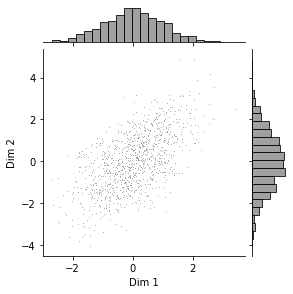

In [10]:
# Your code goes here

mu = np.zeros((2,))
v1 = 1
v2 = 2
rho = 0.6

covar = np.sqrt(v1*v2)*rho
cov = np.array([[v1, covar], [covar, v2]])
x_2d, _, _ = generate_gaussian_data(n_samples=1000, mu=mu, cov=cov, random_seed=10)

# summary statistics -- note the rowvar=False because of the n x d convention
print("Estimated mean:\n{} \n".format(np.mean(x_2d, axis=0)))
print("Estimated covariance matrix:\n{} \n".format(np.cov(x_2d, rowvar=False)))
print("Estimated correlation matrix:\n{}".format(np.corrcoef(x_2d, rowvar=False)))

# plot
g = sns.jointplot(x_2d[:,0],x_2d[:,1], height=4, ratio=5, joint_kws={"s" : 1}, color='grey')
g.set_axis_labels("Dim 1", "Dim 2")
plt.show()

# PCA with sklearn

Sklearn offers a class implementation of `pca`. Please spend a minute to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) of this class. The principal component (PC) directions of a dataset are computed by using the [`fit()`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit) method and stored row-wise in the `components_` attribute. 

The PC scores can be computed by using the [`transform()`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.transform) method. The amount of variance explained by each of the selected components is stored into the `explained_variance_` attribute. 

## Data

We will use a 3-dimensional Gaussian dataset. Execute the cell below to generate the dataset and print the true mean and covariance matrix of the distribution the data was sampled from.

In [11]:
# Generates a 3D dataset and prints true mean and covariance
x_3d, mu_true, C_true = generate_gaussian_data(n_samples=1000, n_features=3, random_seed=20)
print("Dataset consists of {} samples and {} variables/features.\n".format(x_3d.shape[0], x_3d.shape[1]))
print("True mean:\n{}\n".format(mu_true))
print("True covariance matrix:\n{}".format(C_true))

Dataset consists of 1000 samples and 3 variables/features.

True mean:
[0.88389311 0.19586502 0.35753652]

True covariance matrix:
[[ 7.15474605  1.79591767 -0.52284687]
 [ 1.79591767  2.17265    -1.0294186 ]
 [-0.52284687 -1.0294186   0.69419873]]


## Question 4: Computing all PCs

Create a `pca` instance and fit it on the dataset `x_3d`. Print the three PC directions as column vectors. Store the PC scores for `x_3d` in an array called `pc_scores`.

In [12]:
# Your code goes here

from sklearn.decomposition import PCA

pca = PCA() # instantiate PCA model
pca.fit(x_3d) # fit the model
pc_scores = pca.transform(x_3d) # compute scores

print(pca.components_.T)

[[-0.94682757 -0.31374345  0.07129232]
 [-0.30532736  0.80631739 -0.50658413]
 [ 0.10145321 -0.50141532 -0.85923799]]


## Question 5: Computing a subset of PCs

Most often, we do not want to compute all PC directions, but only a few (i.e. dimensionality reduction). We can define the desired number of PCs by setting the [`n_components`]() parameter appropriately when we instantiate the `pca` class. 

Initialise a `pca_new` object with 2 PCs and fit it on the dataset `x_3d`. Compute the corresponding PC scores and print the two PC directions. 

*Hint: the 2 PC directions should be the same as the first 2 directions you computed in the previous question. The reason for this is ultimately that PCA by sequential and simultaneous variance maximisation give the same result.*

In [13]:
# Your code goes here
pca_new = PCA(n_components=2).fit(x_3d) # we can chain the instantiation and the fitting
pc_scores_new = pca_new.transform(x_3d) # compute scores
print(pca_new.components_.T)

[[-0.94682757 -0.31374345]
 [-0.30532736  0.80631739]
 [ 0.10145321 -0.50141532]]


# PCA from scratch

## Question 6: PCA via covariance matrix eigendecomposition

Now we want to implement PCA from scratch using the eigendecomposition of the covariance matrix. The procedure can be summarised as follows:

1. Compute the empirical covariance matrix.
2. Compute the eigendecomposition of the estimated covariance matrix.
3. Sort eigenvalues and associated eigenvectors, in eigenvalue descending order. The sorted eigenvectors correspond to the PC directions. If we want to reduce the dimensionality, we select the first `k` eigenvectors corresponding to the `k` largest eigenvalues (`k` < `d`).
4. To compute PC scores we project the centered data matrix (i.e. matrix product) onto the PC directions.

Some algorithms for eigendecompositions allow you to specify the number of eigenvectors and eigenvalues that should be computed. You then do not have to compute the complete eigendecomposition, which is wasteful if you are only interested in a few principle components. For example, while `numpy`'s `linalg.eigh` computes all eigenvectors and values ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html)), `scipy`'s `linalg.eigh` allows you extract only a subset using the `eigvals`  keyword argument ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh.html)). Note that with scipy v1.5.0 `eigvals` is deprecated and `subset_by_index` should be used.

Compute and print the first two PC directions in the dataset `x_3d` by using the procedure described above, using either `scipy`'s or `numpy`'s `linalg.eigh`. Then compute the PC scores.

As happens very often when writing code, it is likely that there will be a few bugs in your implementation. To check that your code is correct, compare the computed PC directions and scores to the ones obtained with scikit-learn.

*Hint: you might (or might not) find that some of the PC directions/scores you have computed have opposite signs to the ones returned by the sklearn implementation. Do not worry about this, the two solutions are equivalent (why?). To make debugging easier, you are provided with the following function, `solutions_equivalent()` which tests whether two solutions are equivalent, regardless of their signs. Execute the following cell to load this function.*

In [14]:
def solutions_equivalent(b1, b2):
    """Checks whether two PC directions/scores
    solutions are equivalent regardless of their .
    respective signs.
    
    Parameters
    ----------
    
    s1 : array, 
        First solution.
        
    s2 : array, 
        Second solution.
        
    Returns
    -------
    
    True if solutions are equivalent.
    
    Raises
    ------
    
    ValueError if the two bases do not have
    the same dimensionality.
    
    """
    
    s1 = np.asarray(b1)
    s2 = np.asarray(b2)
    
    if s1.shape != s2.shape:
        raise ValueError("Solutions must have the same dimensionality.")
    
    for dim in range(s1.shape[1]):
        if (np.allclose(s1[:,dim],s2[:,dim]) or np.allclose(s1[:,dim],-s2[:,dim])):
            pass
        else:
            return False
    return True

In [15]:
# Your code goes here

WITH_SCIPY = True

n_top = 2  # number of top eigenvectors to compute

mu_est = np.mean(x_3d, axis=0)
C_est = np.cov(x_3d, rowvar=False)
x_3d_centered = x_3d - mu_est
d = C_est.shape[0]

# Eigendecomposition of C
if WITH_SCIPY:
    print('With scipy')
    #eigvals, eigvecs = sp.linalg.eigh(C_est, subset_by_index=[d-n_top, d-1]), newer scipy versions only
    eigvals, eigvecs = sp.linalg.eigh(C_est, eigvals=[d-n_top, d-1]) 
    my_pca_1_directions = eigvecs[:,::-1]  # eigh returns the eigenvalues in ascending order
else:
    print('With numpy')
    eigvals, eigvecs = np.linalg.eigh(C_est) 
    order = np.argsort(eigvals)[::-1]
    my_pca_1_directions = eigvecs[:,order[0:n_top]]

# Compute pc scores
my_pca_1_scores = np.dot(x_3d_centered, my_pca_1_directions)

# Tests
print("Principal components:\n{}".format(my_pca_1_directions))
print(solutions_equivalent(pca_new.components_.T, my_pca_1_directions)) # PC directions
print(solutions_equivalent(pc_scores_new, my_pca_1_scores)) # PC scores

With scipy
Principal components:
[[ 0.94682757  0.31374345]
 [ 0.30532736 -0.80631739]
 [-0.10145321  0.50141532]]
True
True


## Question 7: PCA via  data matrix singular value decomposition (SVD)

Assume we have a centred $d \times n$ data matrix $\mathbf{Y}$ with singular decomposition
$$\mathbf{Y = USV^\top} = \sum_{i=1}^r s_i \mathbf{u}_i \mathbf{v}_i^\top$$
with $s_1\ge s_2 \ge \ldots s_r$ and where $r$ is the rank of the matrix (typically equal to $d$). We have seen in the lecture notes that the best rank $k$ approximation of $\mathbf{Y}$ (measured by the Frobenius norm) is given by 
$$\mathbf{\hat{Y}} = \sum_{i=1}^k s_i \mathbf{u}_i \mathbf{v}_i^\top$$
which means that we can just retain the $k$ terms with the largest singular values. Moreover, we have seen that
* the PC directions are given by the left singular vectors $\mathbf{u}_i$
* the PC scores are given by the scaled right singular values as $\mathbf{z}_i= s_i \mathbf{v}_i^\top$
* the variances of the PC scores are $\lambda_i = s_i^2/n$.

Compute the first two PC directions and scores in the dataset `x_3d` using `scipy.sparse.linalg.svds` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html)). The method allows you to only compute $k$ singular vectors. This is also the method used by sklearn if you choose `arpack` as option for `svd_solver`. Alternatively, you may use `numpy`'s `linalg.svd` ([documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)) but this method computes  the full SVD decomposition, which is wasteful if you are only interested in few components.

Compare the computed PC directions and scores to the ones obtained with scikit-learn.

*Hint: Since `x_3d` is a $n \times d$ matrix, you may best first transpose it to more easily implement the math above, and after the computation, transpose the computed scores back to $n \times k$ form*

In [16]:
from scipy.sparse.linalg import svds

# Your code goes here

n_top = 2 # k=2 components

# centre and transpose
x_3d_centred = x_3d - np.mean(x_3d, axis=0)
Y = x_3d_centred.T # d x n

# svd, which='LM' finds the largest singular values
uk, sk, vkt = svds(Y, k=n_top, which='LM')

# sort since svds does not guarantee sorted outputs
order = np.argsort(sk)[::-1]
my_pca_2_directions = uk[:,order]
my_pca_2_scores_rowvar = sk[order, np.newaxis]*vkt[order, :]  # vkt is n_top x n, 
                                                              # newaxis needed for broadcasting

# revert back to n x k convention for the scores
my_pca_2_scores = my_pca_2_scores_rowvar.T 

# Tests
print("Principal components:\n{}".format(my_pca_2_directions))
print(solutions_equivalent(pca_new.components_.T, my_pca_2_directions)) # PC directions
print(solutions_equivalent(pc_scores_new, my_pca_2_scores)) # PC scores

Principal components:
[[-0.94682757  0.31374345]
 [-0.30532736 -0.80631739]
 [ 0.10145321  0.50141532]]
True
True


# Image compression [optional]

In lecture, we have seen that the SVD allows us to find a low rank approximation of the data matrix. We here exemplify the low rank approximation property of the SVD on a image compression task.

Grey-scale images are represented in the digital world as 2D matrices, whose elements correspond to pixel intensities. We here approximate this matrix by a low-rank approximation through the SVD. If there are correlations between the pixels in the image (which happens to be the case for [natural images](http://www.naturalimagestatistics.net/)), then we should be able to achieve a relatively good reconstruction of the image by using only a few components.

Let us first load a sample image from the scipy package:

In [17]:
# Load sample image
from scipy.misc import face
img = face(gray=True)
print("Image array dimensionality: {}".format(img.shape))

Image array dimensionality: (768, 1024)


We can visualise the image by using the matplotlib imshow function:

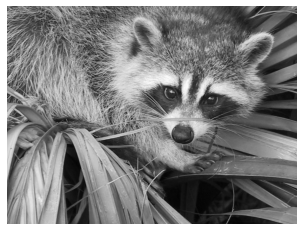

In [18]:
# Show image 
sns.set_style("white")
plt.figure()
plt.imshow(img, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

## Question 8 [optional]

Write a function image_low_rank_approx() that takes as input an image (i.e. 2-dimensional array) and an integer k and reconstructs the image by using a k-rank SVD approximation.

In [19]:
# Your code goes here
def image_low_rank_approx(img, k):
    """Approximates a two-dimensional array by low-rank SVD.
    
    Parameters
    ----------
    
    img : array, ndim = 2
        Image array.
    
    k : integer
        Rank of approximation.
        
    Returns
    -------
    
    img_recon : array, ndim = 2
        Reconstructed image.
    
    """
    
    if img.ndim != 2:
        raise ValueError("Image array should be two-dimensional.")
    
    u, s, v = np.linalg.svd(img, full_matrices=False)
    img_recon = np.dot(u[:,:k]*s[:k], v[:k,:]) # Low-rank approximation
    
    return img_recon

## Question 9 [optional]
Perform a low-rank approximation of the image stored in img by using a varying number of ranks (i.e. from 1 to 500) and visualise the approximation. How many components do you roughly need to obtain a qualitatively decent approximation?

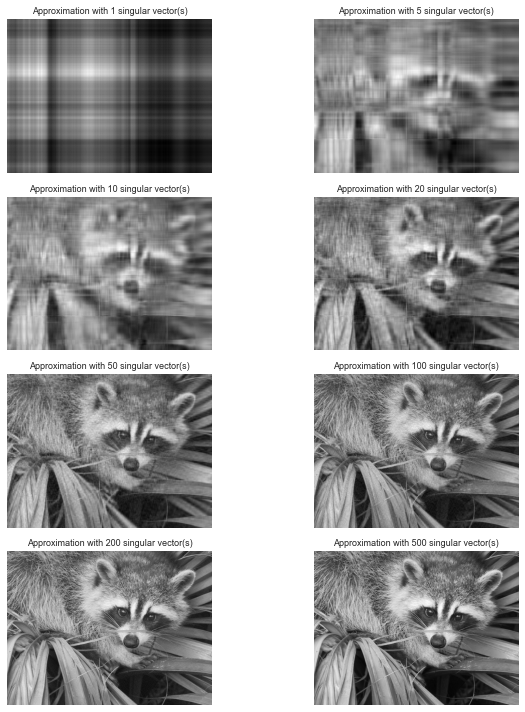

In [20]:
# Your code goes here
k_range = [1, 5, 10, 20, 50, 100, 200, 500]
f = plt.figure(figsize=(10, 10))
for ii, k in enumerate(k_range):
    recon = image_low_rank_approx(img, k)
    plt.subplot(4,2,ii+1)
    plt.imshow(recon, cmap=plt.cm.gray)
    plt.axis('off')
    plt.title("Approximation with {} singular vector(s)".format(k), fontsize=9)
f.tight_layout()

*Your answer goes here.*

We observe that a qualitatively good approximation of the image can be achieved by using as few as 50 singular vectors and values.